In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch
import chess.pgn
from stockfish import Stockfish
import sqlite3
import chess
import graphviz
import chess.polyglot
import torch.autograd as autograd

In [2]:
torch.cuda.set_device(0)
device = torch.device('cuda')
loss_function = nn.MSELoss()

In [3]:
class LinearQuant(autograd.Function):
    @staticmethod
    def forward(ctx, input, weights, bias, s, z):
        minimum = 0
        maximum = 255
        ctx.save_for_backward(input, weights, bias, s, z)
        quantized = torch.round(torch.clamp((weights / s + z), minimum, maximum))
        return (input @ (quantized.T - z) * s) + bias
    
    @staticmethod
    def backward(ctx, grad_output):
        x, weights, bias, s, z = ctx.saved_tensors
        grad_x = grad_w = grad_b = None
        
        grad_x = grad_output @ (weights)
        grad_w = grad_output.T @ x
        grad_b = grad_output.mean(0, True)
        return grad_x, grad_w, grad_b, None, None


In [4]:
class Linear(nn.Module):
    def __init__(self, x, y):
        super().__init__()
        self.min = 0
        self.max = 255
        
        self.weights = nn.parameter.Parameter(torch.randn((y, x)))
        self.bias = nn.parameter.Parameter(torch.randn((1, y)))
        
        self.s = nn.parameter.Parameter((self.weights.max() - self.weights.min()) / (self.max - self.min))
        self.z = nn.parameter.Parameter(self.min - (self.weights.min() / self.s))
        
    def forward(self, x):
        return LinearQuant.apply(x, self.weights, self.bias, self.s, self.z)
#         quantized = torch.round(torch.clamp((self.weights / self.s + self.z), self.min, self.max))
#         with torch.no_grad():
#             quantized = quantized.round()
#         return (x @ (quantized.T - self.z) * self.s) + self.bias
        

In [3]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
#             Linear(384, 16),
            nn.Linear(384, 16),
            nn.ReLU(),
#             Linear(16, 16),
            nn.Linear(16, 16),
            nn.ReLU(),
#             Linear(16, 1),
            nn.Linear(16, 1),
        )
#         for i in range(len(self.layers)):
#             if isinstance(self.layers[i], nn.Linear):
#                 nn.init.kaiming_normal_(self.layers[i].weight, mode='fan_out', nonlinearity='relu')
    def forward(self, x):
        return self.layers(x)
            

In [4]:
# model = Model()
model = torch.load("models/mlp/abc.pt")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model.to(device)

Model(
  (layers): Sequential(
    (0): Linear(in_features=384, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [5]:
def fen_to_bitboard(fen):
    f = torch.zeros((6, 64))
    board = chess.Board(fen)
#     if board.turn == chess.WHITE:
#         a = 1
#         b = -1
#     if board.turn == chess.BLACK:
#         a = -1
#         b = 1
    f[0][list(board.pieces(chess.PAWN, chess.WHITE))] = 1
    f[1][list(board.pieces(chess.KNIGHT, chess.WHITE))] = 1
    f[2][list(board.pieces(chess.BISHOP, chess.WHITE))] = 1
    f[3][list(board.pieces(chess.ROOK, chess.WHITE))] = 1
    f[4][list(board.pieces(chess.QUEEN, chess.WHITE))] = 1
    f[5][list(board.pieces(chess.KING, chess.WHITE))] = 1
    
    f[0][list(board.pieces(chess.PAWN, chess.BLACK))] = -1
    f[1][list(board.pieces(chess.KNIGHT, chess.BLACK))] = -1
    f[2][list(board.pieces(chess.BISHOP, chess.BLACK))] = -1
    f[3][list(board.pieces(chess.ROOK, chess.BLACK))] = -1
    f[4][list(board.pieces(chess.QUEEN, chess.BLACK))] = -1
    f[5][list(board.pieces(chess.KING, chess.BLACK))] = -1
    
    return f.view(1, 384)

In [22]:
def fen_to_stoopid(fen):
    f = torch.zeros((1, 64))
    board = chess.Board(fen)
    if board.turn == chess.WHITE:
        f[0][list(board.pieces(chess.PAWN, chess.WHITE))] = 0.1
        f[0][list(board.pieces(chess.KNIGHT, chess.WHITE))] = 0.2
        f[0][list(board.pieces(chess.BISHOP, chess.WHITE))] = 0.3
        f[0][list(board.pieces(chess.ROOK, chess.WHITE))] = 0.5
        f[0][list(board.pieces(chess.QUEEN, chess.WHITE))] = 0.7
        f[0][list(board.pieces(chess.KING, chess.WHITE))] = 1.0

        f[0][list(board.pieces(chess.PAWN, chess.BLACK))] = -0.1
        f[0][list(board.pieces(chess.KNIGHT, chess.BLACK))] = -0.2
        f[0][list(board.pieces(chess.BISHOP, chess.BLACK))] = -0.3
        f[0][list(board.pieces(chess.ROOK, chess.BLACK))] = -0.5
        f[0][list(board.pieces(chess.QUEEN, chess.BLACK))] = -0.7
        f[0][list(board.pieces(chess.KING, chess.BLACK))] = -1.0

    if board.turn == chess.BLACK:
        f[0][list(board.pieces(chess.PAWN, chess.WHITE))] = -0.1
        f[0][list(board.pieces(chess.KNIGHT, chess.WHITE))] = -0.2
        f[0][list(board.pieces(chess.BISHOP, chess.WHITE))] = -0.3
        f[0][list(board.pieces(chess.ROOK, chess.WHITE))] = -0.5
        f[0][list(board.pieces(chess.QUEEN, chess.WHITE))] = -0.7
        f[0][list(board.pieces(chess.KING, chess.WHITE))] = -1.0

        f[0][list(board.pieces(chess.PAWN, chess.BLACK))] = 0.1
        f[0][list(board.pieces(chess.KNIGHT, chess.BLACK))] = 0.2
        f[0][list(board.pieces(chess.BISHOP, chess.BLACK))] = 0.3
        f[0][list(board.pieces(chess.ROOK, chess.BLACK))] = 0.5
        f[0][list(board.pieces(chess.QUEEN, chess.BLACK))] = 0.7
        f[0][list(board.pieces(chess.KING, chess.BLACK))] = 1.0
    return f

In [6]:
con = sqlite3.connect('test.db')
cur = con.cursor()

In [7]:
def transform(evaluation, fen):
    board = chess.Board(fen)
#     if board.turn == chess.WHITE:
    return (np.arctan(1/2 * evaluation) + np.pi/2)/(np.pi)
#     else:
#         return 1 - ((np.arctan(1/2 * evaluation) + np.pi/2)/(np.pi))
    

In [9]:
size = 1000000
# training dataset
fens_ = cur.execute(f"SELECT fen FROM evaluations LIMIT {size}")
fens = fens_.fetchall()
# board = chess.Board()
# tensors = []
# tensors = [fen_to_bitboard(fens[i][0]) for i in range(size)]
# bits = torch.cat(tensors, dim=0)
# with open('stablecolors.npy', 'wb') as f:
#     np.save(f, bits)

evals_ = cur.execute(f"SELECT eval FROM evaluations LIMIT {size}")
evals = evals_.fetchall()
temp = [transform(evals[i][0], fens[i][0]) for i in range(size)]
evaluations = torch.tensor(temp, dtype=torch.float32)
with open('labels_colorcorrected.npy', 'wb') as f:
    np.save(f, evaluations)


# evaluation dataset
# eval_size = 10000
# e_fen_ = cur.execute(f"SELECT fen FROM evaluations WHERE id > {size} LIMIT {eval_size}")
# e_fen = e_fen_.fetchall()
# tensors = [fen_to_bitboard(e_fen[i][0]) for i in range(eval_size)]
# bits = torch.cat(tensors, dim=0)
# with open('eval_examples.npy', 'wb') as f:
#     np.save(f, bits)

# evaluation_ = cur.execute(f"SELECT eval FROM evaluations WHERE id > {size} LIMIT {eval_size}")
# evaluation = evaluation_.fetchall()
# temp = [((np.arctan(1/2 * evaluation[i][0]) + np.pi/2)/(np.pi)) for i in range(eval_size)]
# evaluations = torch.tensor(temp)
# with open('eval_labels.npy', 'wb') as f:
#     np.save(f, evaluations)

# plt.style.use('_mpl-gallery')

# # make data
# np.random.seed(1)

# # plot:
# fig, ax = plt.subplots()

# ax.hist(x, bins=100, linewidth=0.5, edgecolor="white")

# ax.set(xlim=(-2, 2), xticks=np.arange(1, 1),
#        ylim=(0, 1000), yticks=np.linspace(0, 1000, 9))

# plt.show()

In [7]:
losses = []
# eval_losses = []

bits = torch.from_numpy(np.load("datasets\mlp\stablecolors.npy")).to(device)
labels = torch.from_numpy(np.load("datasets\mlp\labels_colorcorrected.npy")).to(device)

# eval_examples = torch.from_numpy(np.load("eval_examples.npy")).to(device)
# eval_labels = torch.from_numpy(np.load("eval_labels.npy")).to(device)

In [8]:
# model training
# https://stackoverflow.com/questions/45113245/how-to-get-mini-batches-in-pytorch-in-a-clean-and-efficient-way
n_epochs = 100 # or whatever
batch_size = 128 # or whatever

for epoch in range(n_epochs):
    # X is a torch Variable
    permutation = torch.randperm(bits.size()[0])
#     eval_permutation = torch.randperm(bits.size()[0])
#     for i in range(0, eval_examples.size()[0], batch_size):
#         indices = eval_permutation[i:i+batch_size]
#         batch_x, batch_y = bits[indices], labels[indices]
#         outputs = model(batch_x)
        
#         loss = loss_function(outputs, batch_y.view(-1, 1))
#         eval_losses.append(loss.item())
        
    for i in range(0, bits.size()[0], batch_size):
        optimizer.zero_grad()

        indices = permutation[i:i+batch_size]
        batch_x, batch_y = bits[indices], labels[indices]
        
        outputs = model(batch_x)
        loss = loss_function(outputs, batch_y.view(-1, 1))
        losses.append(loss.item())

        loss.backward()
        optimizer.step()

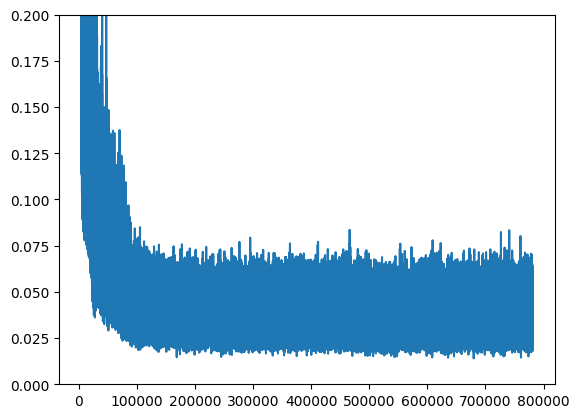

In [9]:
start = 5000
smooth = 1

x = np.arange(len(losses)/smooth)
y = torch.tensor(losses).view(smooth, -1).mean(0)
plt.plot(x[start:], y[start:])

# e_x = np.arange(0, (len(eval_losses)/smooth) * 100, 100)
# e_y = torch.tensor(eval_losses).view(smooth, -1).mean(0)
# plt.plot(e_x[int(start/100):], e_y[int(start/100):])

plt.ylim(0, 0.2)
plt.show()

In [10]:
sum(losses[len(losses) - 100:]) / 100

0.036075441129505635

In [19]:
size = 1000
# training dataset
fens_ = cur.execute(f"SELECT fen FROM evaluations WHERE id > 1000000 LIMIT {size}")
fens = fens_.fetchall()

evaluation_ = cur.execute(f"SELECT eval FROM evaluations WHERE id > 1000000 LIMIT {size}")
evaluations = evaluation_.fetchall()

# fig, ax = plt.subplots()

qmin = 0
qmax = 256

w = list(model.parameters())

w1 = w[0].detach().cpu()
w1_S = (w1.max() - w1.min()) / (qmax - qmin)
w1_Z = qmin - (w1.min() / w1_S)
q_w1 = (w1 / w1_S + w1_Z).clamp(qmin, qmax).round()

b1 = w[1].detach().cpu()
q_b1 = (b1/w1_S + 0).clamp(-2147483648, 2147483647).round() # this clamping doesn't do anything :)

w2 = w[2].detach().cpu()
w2_S = (w2.max() - w2.min()) / (qmax - qmin)
w2_Z = qmin - (w2.min() / w2_S)
q_w2 = (w2 / w2_S + w2_Z).clamp(qmin, qmax).round()

b2 = w[3].detach().cpu()
q_b2 = (b2/w2_S + 0).clamp(-2147483648, 2147483647).round()

w3 = w[4].detach().cpu()
w3_S = (w3.max() - w3.min()) / (qmax - qmin)
w3_Z = qmin - (w3.min() / w3_S)
q_w3 = (w3 / w3_S + w3_Z).clamp(qmin, qmax).round()

b3 = w[5].detach().cpu()
q_b3 = (b3/w3_S + 0).clamp(-2147483648, 2147483647).round()

relu = nn.ReLU()
# L = []
# for i in w1.int():
#     L.append(i.item())
# print(L)
diff = []
real = []
quant = []
# quants = 0
# quantz = 0
q1_S = q2_S = q3_S = q4_S = 1
q1_Z = q2_Z = q3_Z = q4_Z = 0
for i in range(1000):
#     fen = "rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq e3 0 1"
    fen = fens[i][0]
    a = fen_to_bitboard(fen)
    
#     # real
    r = (a @ w1.T) + b1
    r = relu(r)
    r = (r @ w2.T) + b2
    r = relu(r)
    r = (r @ w3.T) + b3

#     # quantb
    q = (a @ (q_w1.T - w1_Z) * w1_S/q1_S) + q1_Z + q_b1
    q = q + 
    
    q1_S = ((q.max() - q.min()) / (qmax - qmin)) * 0.1 + 0.9 * q1_S
    q1_Z = (qmin - (q.min() / q1_S)) * 0.5 + 0.5 * q1_Z
    
    q = (((q - w1_Z) @ (q_w2.T - w2_Z)) * ((w2_S * q1_S)/q2_S)) + q2_Z + q_b2
    
    q2_S = ((q.max() - q.min()) / (qmax - qmin)) * 0.5 + 0.5 * q2_S
    q2_Z = (qmin - (q.min() / q2_S)) * 0.5 + 0.5* q2_Z
    
    q = ((q - q2_Z) @ (q_w3.T - w3_Z) * ((w3_S * q2_S)/q3_S)) + q3_Z + q_b3
         
    q3_S = ((q.max() - q.min()) / (qmax - qmin)) * 0.5 + 0.5 * q3_S
    q3_Z = (qmin - (q.min() / q3_S)) * 0.5 + 0.5 * q3_Z
    print(q)
    
    real.append(r[0][0].item())
    quant.append(q[0][0].item())
    diff.append((q - transform(evaluations[i][0], None))**2)
#     quants += -torch.min(q)+torch.max(q)
#     quantz += (torch.min(q)+torch.max(q))/2
# plt.scatter(real, quant);
print(sum(diff)/len(diff))
# print(q_w2.T)
# plt.hist(w1.view(1, -1), 100);
# print(quants/1000)
# print(quantz/1000)

# print(r)
# print(q)
# print(q)
# print(w3_Z.item())
# for i in b3:
#     print(i.item(), end=", ")

tensor([[-9796.1660]])
tensor([[8451.5566]])
tensor([[-15485.4326]])
tensor([[48267.0273]])
tensor([[-372750.7188]])
tensor([[5758141.]])
tensor([[-1.8142e+08]])
tensor([[1.1520e+10]])
tensor([[-1.4688e+12]])
tensor([[3.7528e+14]])
tensor([[-1.9195e+17]])
tensor([[1.9646e+20]])
tensor([[-4.0226e+23]])
tensor([[1.6475e+27]])
tensor([[-1.3495e+31]])
tensor([[2.2110e+35]])
tensor([[-inf]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
te

tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([[nan]])
tensor([

In [105]:
for row in range(q_w1.T.shape[0]):
    for col in range(q_w1.T.shape[1]):
        print(q_w1.T[row, col].item(), end=", ")
    print()

131.0, 123.0, 135.0, 132.0, 127.0, 130.0, 131.0, 136.0, 127.0, 132.0, 141.0, 135.0, 145.0, 141.0, 123.0, 128.0, 
121.0, 135.0, 139.0, 114.0, 126.0, 129.0, 130.0, 127.0, 127.0, 127.0, 147.0, 146.0, 138.0, 140.0, 132.0, 133.0, 
125.0, 135.0, 137.0, 128.0, 139.0, 129.0, 136.0, 135.0, 123.0, 135.0, 139.0, 128.0, 138.0, 122.0, 134.0, 127.0, 
138.0, 125.0, 130.0, 132.0, 131.0, 125.0, 130.0, 141.0, 134.0, 142.0, 133.0, 126.0, 129.0, 135.0, 145.0, 130.0, 
133.0, 134.0, 130.0, 135.0, 132.0, 135.0, 134.0, 136.0, 138.0, 133.0, 138.0, 141.0, 141.0, 127.0, 120.0, 131.0, 
122.0, 137.0, 128.0, 136.0, 147.0, 132.0, 134.0, 148.0, 116.0, 121.0, 130.0, 135.0, 143.0, 128.0, 145.0, 130.0, 
120.0, 119.0, 145.0, 133.0, 143.0, 146.0, 141.0, 134.0, 138.0, 129.0, 123.0, 119.0, 120.0, 141.0, 130.0, 131.0, 
140.0, 129.0, 142.0, 126.0, 141.0, 137.0, 123.0, 118.0, 128.0, 125.0, 141.0, 149.0, 130.0, 130.0, 122.0, 142.0, 
130.0, 85.0, 139.0, 138.0, 96.0, 153.0, 132.0, 133.0, 137.0, 145.0, 138.0, 141.0, 113.0, 128.0, 

In [69]:
for row in range(q_w1.T.shape[0]//4):
    for col in range(q_w1.T.shape[1]//4):
        print(q_w1.T[row*4:row*4+4, col*4:col*4+4])
#     print()

tensor([[131., 123., 135., 132.],
        [121., 135., 139., 114.],
        [125., 135., 137., 128.],
        [138., 125., 130., 132.]])
tensor([[127., 130., 131., 136.],
        [126., 129., 130., 127.],
        [139., 129., 136., 135.],
        [131., 125., 130., 141.]])
tensor([[127., 132., 141., 135.],
        [127., 127., 147., 146.],
        [123., 135., 139., 128.],
        [134., 142., 133., 126.]])
tensor([[145., 141., 123., 128.],
        [138., 140., 132., 133.],
        [138., 122., 134., 127.],
        [129., 135., 145., 130.]])
tensor([[133., 134., 130., 135.],
        [122., 137., 128., 136.],
        [120., 119., 145., 133.],
        [140., 129., 142., 126.]])
tensor([[132., 135., 134., 136.],
        [147., 132., 134., 148.],
        [143., 146., 141., 134.],
        [141., 137., 123., 118.]])
tensor([[138., 133., 138., 141.],
        [116., 121., 130., 135.],
        [138., 129., 123., 119.],
        [128., 125., 141., 149.]])
tensor([[141., 127., 120., 131.],
       

In [16]:
def quant_evaluation(a):
    qmin = 0
    qmax = 255
    
    relu = nn.ReLU()
    
    w = list(model.parameters())

    w1 = w[0].detach().cpu()
    w1_S = (w1.max() - w1.min()) / (qmax - qmin)
    w1_Z = qmin - (w1.min() / w1_S)
    q_w1 = (w1 / w1_S + w1_Z).clamp(qmin, qmax).round()

    b1 = w[1].detach().cpu()

    w2 = w[2].detach().cpu()
    w2_S = (w2.max() - w2.min()) / (qmax - qmin)
    w2_Z = qmin - (w2.min() / w2_S)
    q_w2 = (w2 / w2_S + w2_Z).clamp(qmin, qmax).round()

    b2 = w[3].detach().cpu()

    w3 = w[4].detach().cpu()
    w3_S = (w3.max() - w3.min()) / (qmax - qmin)
    w3_Z = qmin - (w3.min() / w3_S)
    q_w3 = (w3 / w3_S + w3_Z).clamp(qmin, qmax).round()

    b3 = w[5].detach().cpu()

#     # quantb
    q = (a @ (q_w1.T - w1_Z))
    q = relu(q)
    q = (q @ (q_w2.T - w2_Z) * w2_S) + b2
    q = relu(q)
    q = (q @ (q_w3.T - w3_Z) * w3_S) + b3
    return q

In [99]:
print(w1_Z.item())

132.43197631835938


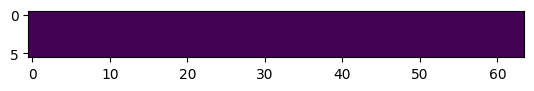

In [6]:
b = fen_to_bitboard("rnbqkbnr/ppp1ppp1/3p4/7p/1P1P4/8/P1P1PPPP/RNBQKBNR w KQkq - 0 3")
a = torch.tensor((0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, -1, 0, 0, 0, 0, -1, -1, -1, 0, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, -1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, -1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, ))
plt.imshow((b.view(6, -1)) - (a.view(6, -1)))
# plt.imshow((a.view(6, -1)))
# plt.imshow((b.view(6, -1)))


In [119]:
'{0:04b}'.format(15)

'1111'

In [101]:
temp = torch.zeros((3, 16))
tempington = torch.cat((q_w3, temp), dim=0)

In [116]:
compressed = []
bits = 8
for row in range(q_w1.T.shape[0]//4):
    for col in range(q_w1.T.shape[1]//4):
        L = list([int(i.item()) for i in q_w1.T[row*4:row*4+4, col*4:col*4+4].flatten()])
        for param in range(int(len(L)/bits)):
            string = ""
            for number in L[param*8:param*8+8]:
                string += '{0:08b}'.format(number)
        #     print(string)
            compressed.append(int(string, 2))
print(len(compressed))

768


In [25]:
size = 1000000

# evaluation dataset
eval_size = 1000
e_fen_ = cur.execute(f"SELECT fen FROM evaluations WHERE id > {size} LIMIT {eval_size}")
e_fen = e_fen_.fetchall()
tensors = [fen_to_bitboard(e_fen[i][0]) for i in range(eval_size)]
bits = torch.cat(tensors, dim=0)

evaluation_ = cur.execute(f"SELECT eval FROM evaluations WHERE id > {size} LIMIT {eval_size}")
evaluation = evaluation_.fetchall()
# temp = [((np.arctan(1/2 * evaluation[i][0]) + np.pi/2)/(np.pi)) for i in range(eval_size)]
temp = [transform(evaluation[i][0], None) for i in range(eval_size)]
evaluations = torch.tensor(temp)

model.eval()
losses = []

for i in range(eval_size):
#     loss = loss_function(model(bits[i].to(device)).view(-1), evaluations[i].to(device).view(-1))
    loss = loss_function(quant_evaluation(bits[i].view(-1), evaluations[i].view(-1))
    losses.append(loss.item())
print(sum(losses) / len(losses))

SyntaxError: '(' was never closed (2911374201.py, line 21)

In [8]:
def evaluation(fen):
    model.eval()
    score  = model(fen_to_bitboard(fen).to(device))
    model.train()
    return score.item()

In [24]:
class Node():
    def __init__(self, fen, parent, color, move):
        self.fen = fen
        self.parent = parent
        self.children = None
        self.visits = 0
        self.prior = 0
        self.wins = 0
        self.color = color
        self.move = move

In [25]:
def minimax(board, depth, alpha, beta):
    moves = list(board.legal_moves)
    if depth == 1:
        tensors = []
        for m in moves:
            board.push(m)
            tensors.append(fen_to_bitboard(board.fen()).to(device))
            board.pop()
        model.eval()
        logits = model(torch.cat(tensors, dim=0))
        model.train()
        if board.turn == chess.WHITE:
            return torch.max(logits).item(), None
        else:
            return torch.min(logits).item(), None
    if board.turn == chess.WHITE:
        maxScore = -1000
        best_move = None
        for m in moves:
            board.push(m)
            score, _ = minimax(board, depth-1, alpha, beta)
            if score > maxScore:
                maxScore = score
                best_move = m
            board.pop()
            alpha = max(alpha, score)
            if beta <= alpha:
                break
        if depth < 3:
            return maxScore, None
        if depth == 3:
            return maxScore, best_move
    else:
        minScore = 1000
        best_move = None
        for m in moves:
            board.push(m)
            score, _ = minimax(board, depth-1, alpha, beta)
            if score < minScore:
                minScore = score
                best_move = m
            board.pop()
            beta = min(beta, score)
            if beta <= alpha:
                break
        if depth < 3:
            return minScore, None
        if depth == 3:
            return minScore, best_move

In [19]:
def expand_node(node, color):
    board = chess.Board(node.fen)
    moves = list(board.legal_moves)
    nodes = []
    
    tensors = []

    for move in moves:
        board.push(move)
        n = Node(board.fen(), node, board.turn, move)
        nodes.append(n)
        tensors.append(fen_to_bitboard(n.fen).to(device))
        board.pop()

    node.children = nodes
    
    if len(node.children) > 0:
        model.eval()
        logits = model(torch.cat(tensors, dim=0))
        
        if node.color == False:
            for i, child in enumerate(node.children):
                child.prior = (1 - logits[i].item())
            return float(1 - sum(logits) / len(logits))
        else:
            for i, child in enumerate(node.children):
                child.prior = (logits[i].item())
            return float(sum(logits) / len(logits))
        model.train()

def select_child(node):
    best_node = None
    
    best = -np.inf
    for child in node.children:
        if child.visits > 0:
            val = child.wins / child.visits + np.sqrt(2) * np.sqrt(np.log(node.visits) / (child.visits))
        else:
            val = child.prior + np.sqrt(2) * np.sqrt(np.log(node.visits) / (child.visits + 1))
#         print(f"{child.move} {child.visits} {child.prior:.3f} {child.wins:.3f} {val:.4f} {node.visits}")
        if val > best:
            best = val
            best_node = child
    
#     print(best_node.move)
    return best_node

def backpropagate(node, score, color):
    while node is not None:
        node.visits += 1
        if color == node.color:
            node.wins += score
        else:
            node.wins += (1 - score)
        node = node.parent

def search(board):
    root = Node(board.fen(), None, board.turn, None)

    for _ in range(1000):
        # Selection and expansion
        current = root
        while current.children is not None:
            current = select_child(current)
#         print()

        if current.visits == 0:
            # If the node has not been visited yet, expand it
            score = expand_node(current, current.color)

        # Simulation
        score = current.prior

        # Backpropagation
        backpropagate(current, score, current.color)

    # Choose the best move based on visits
    best_visits = -1
    best_move = ""

    for node in root.children:
        print(f"{node.move} {node.visits} {node.prior:.3f} {node.wins:.3f} {(node.wins/(node.visits)):.4f}")
        if node.visits > best_visits:
            best_visits = node.visits
            best_move = node.move
    
    return best_move

In [50]:
fen = "rnb1kbnr/pp1ppppp/2p5/7Q/3qP1PP/1PNB1P2/P1PB4/1KNR3R w kq - 5 17"
board = chess.Board(fen)
print(minimax(board, 3, -1000000, 1000000))
# search(board)

(0.8731439113616943, Move.from_uci('c1e2'))


In [118]:
# white
fen = "rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1"
board = chess.Board(fen)
moves = list(board.legal_moves)

scores = {}
best_score = -1000
best_move = ""
for m in moves:
    board.push(m)
    score = quant_evaluation(fen_to_bitboard(board.fen()))
    print(str(score[0, 0].item()) + " " + str(m))
    scores[m] = score
    board.pop()
# d_sorted = sorted(zip(scores.values(), scores.keys()))
# for i in d_sorted:
#     print(i)
# print(sum(scores) / len(scores))

-203.0 g1h3
-157.0 g1f3
-128.0 b1c3
-138.0 b1a3
-173.0 h2h3
-177.0 g2g3
-163.0 f2f3
-144.0 e2e3
-135.0 d2d3
-159.0 c2c3
-166.0 b2b3
-174.0 a2a3
-170.0 h2h4
-170.0 g2g4
-173.0 f2f4
-139.0 e2e4
-126.0 d2d4
-156.0 c2c4
-153.0 b2b4
-165.0 a2a4


In [38]:
# black
fen = "rnbqkb1r/ppp2ppp/3ppn2/4P3/8/5N2/PPPP1PPP/RNBQKB1R w KQkq - 0 4"
# board = chess.Board(fen)
# moves = list(board.legal_moves)
print(quant_evaluation(fen_to_bitboard(fen)))

# scores = []
# best_score = 1000
# best_move = ""
# for m in moves:
#     board.push(m)
#     score = evaluation(board.fen())
#     scores.append(score)
#     print(f"{score} {m}")
#     if score < best_score:
#         best_score = score
#         best_move = m
#     board.pop()
# print(best_move)
# print(1 - sum(scores) / len(scores))

tensor([[0.4958]])


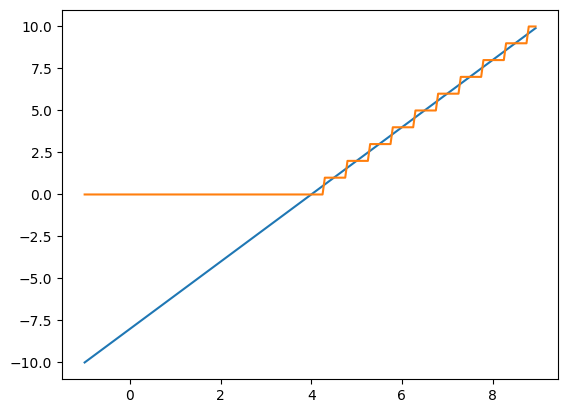

In [62]:
x = np.arange(-1, 9, .05)
y = np.arange(-10, 10, .1)
plt.plot(x, y)
y = [np.round(max(0, i)) for i in y]
plt.plot(x, y)

In [54]:
a = torch.rand((2, 16))
b = torch.rand((16, 4))
# (1, 16) @ (16, 4) = (1, 4)

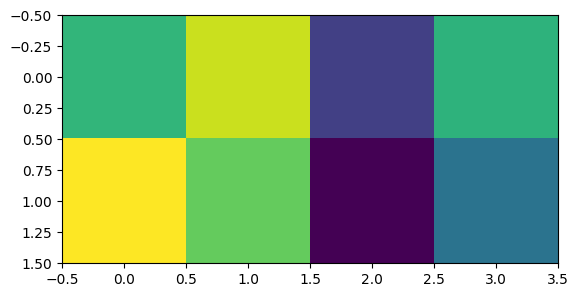

In [55]:
plt.imshow(a @ b)

In [54]:
for r in b:
    for c in r:
        print(c.item(), end="f, ")


0.09802323579788208f, 0.09665560722351074f, 0.5750908255577087f, 0.7510685920715332f, 0.9153562784194946f, 0.4323890209197998f, 0.5761985778808594f, 0.5010663866996765f, 0.10167789459228516f, 0.07291549444198608f, 0.2576272487640381f, 0.6675180792808533f, 0.26626837253570557f, 0.5234975218772888f, 0.9565550088882446f, 0.22243601083755493f, 0.3465682864189148f, 0.815252959728241f, 0.015560150146484375f, 0.8576486110687256f, 0.3054353594779968f, 0.302367627620697f, 0.5751824378967285f, 0.5659737586975098f, 0.5978508591651917f, 0.8426461219787598f, 0.6160740852355957f, 0.39441657066345215f, 0.6221723556518555f, 0.22485774755477905f, 0.4202009439468384f, 0.48693448305130005f, 0.1583150029182434f, 0.5939502716064453f, 0.9476490616798401f, 0.18271297216415405f, 0.8026080131530762f, 0.5528708696365356f, 0.643247127532959f, 0.9439643025398254f, 0.04886424541473389f, 0.9725059270858765f, 0.539108157157898f, 0.6467350721359253f, 0.32848089933395386f, 0.9851852655410767f, 0.06277245283126831f, 0.

In [49]:
for r in b:
    print("{", end="")
    for c in r:
        print(c.item(), end=", ")
    print("}, ", end="")

{6, 6, 5, 6, 6, 6, 7, 1, 3, 7, 5, 0, 4, 0, 6, 8, }, {4, 8, 3, 9, 0, 3, 9, 9, 2, 9, 7, 8, 3, 6, 1, 5, }, {7, 8, 5, 7, 7, 3, 4, 5, 5, 1, 8, 2, 6, 1, 5, 1, }, {7, 8, 3, 4, 3, 5, 5, 8, 9, 7, 4, 4, 0, 6, 2, 1, }, {7, 6, 4, 9, 1, 5, 5, 9, 3, 9, 8, 8, 2, 2, 9, 2, }, {3, 4, 1, 8, 9, 2, 9, 1, 2, 6, 7, 6, 1, 9, 3, 9, }, {7, 9, 2, 9, 3, 7, 8, 9, 1, 2, 1, 6, 6, 0, 2, 4, }, {9, 4, 1, 3, 5, 8, 8, 0, 3, 0, 2, 4, 2, 8, 4, 8, }, {8, 5, 9, 6, 9, 6, 9, 2, 5, 1, 7, 7, 8, 2, 1, 4, }, {6, 8, 6, 5, 1, 7, 4, 8, 6, 8, 8, 8, 8, 9, 3, 3, }, {8, 1, 6, 5, 4, 0, 4, 3, 0, 3, 4, 9, 6, 3, 7, 3, }, {9, 8, 5, 7, 6, 1, 6, 8, 8, 8, 6, 9, 4, 1, 1, 8, }, {2, 4, 5, 4, 6, 7, 3, 6, 9, 4, 6, 0, 9, 2, 4, 8, }, {7, 5, 5, 1, 5, 2, 4, 7, 4, 8, 3, 3, 7, 8, 4, 3, }, {5, 2, 1, 0, 4, 4, 3, 3, 1, 0, 4, 5, 1, 5, 1, 6, }, {2, 0, 5, 4, 5, 2, 6, 9, 5, 6, 0, 5, 0, 2, 8, 6, }, 

In [49]:
a @ b

tensor([[0.2434, 0.5760, 0.7501, 1.0267],
        [0.6287, 0.9836, 1.5447, 1.7224],
        [0.2930, 0.5350, 0.4950, 0.9322],
        [0.6117, 0.8212, 0.8646, 1.1010]])

In [32]:
print(a.shape)
print(b.shape)
for row in range(1):
    for col in range(1):
        c = torch.zeros((4, 4))
        for i in range(4):
            print(a[row*4:row*4+4, i*4:i*4+4])
            print(b[i*4:i*4+4, col*4:col*4+4])
            c += a[row*4:row*4+4, i*4:i*4+4] @ b[i*4:i*4+4, col*4:col*4+4]
# torch.max(c - (a @ b))

torch.Size([4, 16])
torch.Size([16, 4])
tensor([[ 1.6764, -0.5967,  0.7432, -1.6759],
        [ 0.0644,  1.0129, -0.2032, -1.5021],
        [-0.5312,  0.2616,  1.5954, -0.7782],
        [ 0.3293, -0.7948, -0.1705,  0.1084]])
tensor([[-1.4335, -1.5384,  0.1661,  0.0183],
        [-0.0152, -0.6636, -1.2570,  0.1718],
        [-2.0307,  0.0535,  0.7373,  0.5048],
        [-1.3098, -0.2302,  1.0360,  1.1701]])
tensor([[-2.0151,  0.8615,  0.1116,  1.0290],
        [-1.5374,  1.5765, -0.3632, -0.3616],
        [-1.6024, -0.9151,  0.1957, -0.5774],
        [ 0.1745,  1.4125, -0.5483, -0.4575]])
tensor([[ 0.1910,  0.1956, -0.4993,  0.6733],
        [ 0.3484,  0.3087,  0.8932, -0.3334],
        [-0.5421,  2.3386,  1.7344,  0.5666],
        [ 1.3201,  1.0652, -0.9892, -0.6864]])
tensor([[ 1.3639, -0.3597, -1.3043, -0.4681],
        [-0.5600,  0.2358, -0.3419, -0.7324],
        [ 1.5405, -0.6913,  0.2770,  0.4174],
        [ 1.0426, -0.8042,  0.3397, -0.2514]])
tensor([[ 1.6215, -0.9752,  0.4873,

In [31]:
print(a@b)

tensor([[ 1.7558, -2.2515, -1.6547, -5.1124],
        [ 0.9204, -1.1286, -3.7277, -7.7244],
        [-1.2007, -6.4726,  2.8340,  2.0231],
        [ 1.2364, -3.9532,  3.1513,  3.8164]])


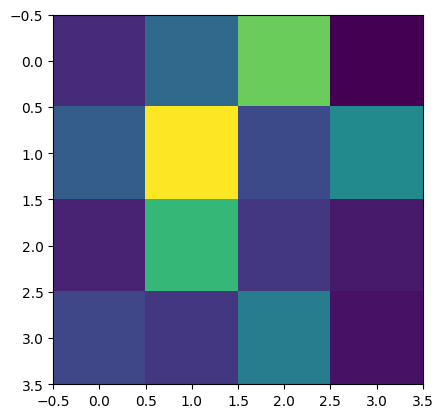

In [9]:
plt.imshow(a[0*4:0+4, 1*4:1*4+4])

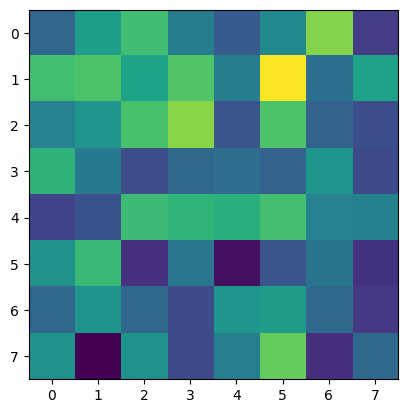

In [6]:
plt.imshow(a)